## Hacking for Defense: An Effort to Create a Cybersecurity Risk Evaluation Metric

### Data Science II: Applied Statistical Learning - Spring 2022 - Georgetown University<br/>Ryan Ripper<br/>05/09/2022

#### 1. Introduction

Is there a way to systematically identify a company as being a potential cybersecurity target from online attacks? Cybersecurity is the practice of protecting systems, networks, and programs from digital attacks. Attacks on online platforms usually attempt to access, change, or destroy sensitive information; extort money from users; or interrupt normal business processes. Cybersecurity attacks also have the capacity to suppress certain social and political activity, to steal intellectual property, and to harm regional and international adversaries.

This paper starts with our collaboration with Hacking for Defense (H4D) Spring 2022. H4D is a class offered at Georgetown University sponsored by the Department of Defense that teaches students to work with the Defense and Intelligence Communities to rapidly address the nation’s emerging threats and security challenges. Students work with sponsors to address government concerns in solving specific, mission critical problems while allowing students to investigate their interests in the given field. This semester’s class has been tasked with creating a standardized evaluation metric to address the cybersecurity risk posed by defense companies working with the government. This metric will work to prioritize mitigation methods and to prevent cybersecurity incidents for the National Security Agency (NSA) Defense Industrial Base (DIB).

The NSA hopes to alleviate the burden of evaluating over 100,000 DIB companies by identifying those who present the greatest cybersecurity target. The H4D project plans to scale the services the NSA currently conducts on a small-scale cyber security-as-a-service pilots to DIB companies. There is currently no standardization evaluation metric of business cybersecurity risk while little is known about the business risk posed by companies not in the insurance industry. Thus, the class's proposal and our research question both plan to address the complexity of the problem posed by the NSA in identifying companies that would benefit from additional cybersecurity support. This support will contribute to critical technology suppliers that would seemingly pose as financial, political, technical, and/or military targets. The policy implications related to this project involve the proper identification and allocation of resources from government entities to protect the interests of American development for critical and emerging technologies, which have been designated by the Pentagon as instruments that could dictate the outcomes of future conflicts.

In order to answer our primary research question, we examine contracts and the corresponding awards given by the United States government. With these contracts can we understand the significance of a company within the development of an emerging technology. We start our analysis by focusing on hypersonic technologies. This technology has the potential to further destabilize nations with the speedy deployment of nuclear missiles, is uniquely situated as a “lagging” technology with respect to the United States amongst its foreign adversaries, and is a personal interest to the authors with respect to advanced aerospace technologies and applications. These hypersonic awards and all contracts in general are made available by USAspending which is the official open data source of federal spending information. We focus on published subawards as these provide further insight to all developers, not just the main contributors. By evaluating at the subaward scale, we expand our scope of companies involved in hypersonic technology development outside the main developers such as Raytheon, Northrop Grumman, and Lockheed Martin.

We can supplement the USAspending data by including other features to the main dataset. In our attempt to collect additional data to map to our data from USAspending, we have two options: to match on a company's Data Universal Numbering System, or D-U-N-S, number which is a proprietary identifier given by the firm Duns & Bradstreet or on a company's name. Matching on a company's D-U-N-S number relies on using the Duns & Bradstreet Application Programming Interface (API), with which we did not have any success. Matching on a company's name relies on consistent naming conventions across multiple sources, which we cannot accurately trust. Thus, our efforts lay in the use of subaward contract information provided by USAspending. We can also understand our analysis as an effort to stretch the information we can learn from subaward contract data. We evaluate data from USAspending from the calendar year 2021 so that we have the latest full years’ worth of contract information.

Working with H4D, we were tasked as data scientists to data wrangle and develop machine learning models to identify companies that could be cybersecurity targets and to develop a risk evaluation metric as a continuously monitoring tool. Data wrangling provides an initial effort to identify at-risk companies. Machine learning will help us develop a model to continue our identification of at-risk companies and to hopefully predict attacks.

However, without additional information outside USAspending, our effort to create a cybersecurity risk evaluation metric stalls as we do not have enough identifiers to predict a potential attack since we do not have data on past cybersecurity attacks. We cannot create supervised prediction models to anticipate these attacks since we do not have a specific dependent variable with which to train our models. Since there are no federal laws requiring the disclosure of events like data breaches, obtaining a list of past cybersecurity attacks will be incredibly challenging. Furthermore, if we were to have a list of past cybersecurity attacks across the companies included in USAspending, there would be a select number of companies that had been victims of attacks. We would have an extremely imbalanced class distribution amongst those companies who had been attacked versus those who had not. We could address this imbalance by oversampling the positive class (those who had been attacked) but would have these observations repeated many times over, resulting in overfitting for some models.

With this obstacle came our decision to pivot our focus to identifying companies that would first be prone to cyber security attacks, dictating a reason to support these companies with government response and then to find any anomalies in the data. Our subsequent results and analysis focus on comparisons between all subaward contracts and hypersonic subaward contracts. We develop unsupervised machine learning models to gain further insight to the USAspending data.

Ultimately, we were able to identify DIB companies that could be cybersecurity targets. These companies exhibited a lacking focus on Information Technology infrastructure and attracted specific attention regarding their accomplishments in hypersonic technology across domestic and international media outlets.

#### 2. Main Results and Analysis

We begin by first loading in the data from USAspending for all subawards given in the calendar year 2021.

In [1]:
# Import necessary Python modules.
from pycaret.anomaly import *
import pandas as pd
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Add additional settings to notebook.
warnings.filterwarnings("ignore")

In [2]:
# Read in all subaward data.
data_sub_awards_all = \
(pd
 .read_csv("All_Contracts_Subawards_2022-04-12_H19M40S39_1.csv")
)

In [3]:
# Check size of all subaward data.
data_sub_awards_all.shape

(162207, 107)

We distinguish hypersonic subawards from all contracts.

In [4]:
# Only collect hypersonic subawards.
data_sub_awards_hyper = \
data_sub_awards_all[(data_sub_awards_all["prime_award_description"]
                     .str
                     .lower()
                     .str
                     .contains("hypersonic", regex = False)
                    )]

In [5]:
# Identify the top 10 subaward descriptions for hypersonic.
top_descriptions_hyper = \
(data_sub_awards_hyper[["subaward_description", "subaward_amount"]]
 .groupby(["subaward_description"])
 .agg({
     "subaward_amount" : ["mean", "count"]
 })
 .reset_index()
 .rename(columns = {"" : "Sub-Award Description", 
                    "mean" : "Sub-Award Average Amount",
                    "count" : "Sub-Award Count"
                   }, level = 1)
 .round(2)
 .droplevel(0, axis = 1)
 .sort_values(by = ["Sub-Award Count"], ascending = False)
 .dropna()
 .head(10)
)[["Sub-Award Description"]]

# Show results.
display(top_descriptions_hyper)

Sub-Award Description
59  The contractor shall provide the following ser...
40  Material/ODC to support the requirement specif...
43  ODC/MATERIAL to support TDO "Hypersonic Threat...
34                                                IMU
41                                       NRE - Other.
52                           SERVICE PLASMA PROCESSES
51                           SERVICE AAVID THERMACORE
11                                      AC355550N/720
1   3.1 Purchase and execute hardware/Software (HW...
39                        MR&D MACH RULES SUBCONTRACT

__Table 1.__ Top 10 Subaward Descriptions for Hypersonic Contracts

Table 1 shows the top descriptions with the most number of subawards given. These descriptions are lengthy and do not necessarily give much insight into the contract itself nor the work the company is doing to contribute to hypersonic technology development. We can extend these results to find the companies that have these descriptions in common with their contracts and find those companies with the top number of awards.

In [6]:
# Merge all subaward data with the top descriptions for hypersonic.
data_top_descriptions_hyper = \
(data_sub_awards_hyper
 .merge(top_descriptions_hyper, how = "inner", left_on = "subaward_description", right_on = "Sub-Award Description")
)

In [7]:
# Collect results for the companies that have the most contracts for the top descriptions for hypersonic.
results_hyper = \
(data_top_descriptions_hyper[["subawardee_name", "subaward_description", "subaward_amount"]]
 .groupby(["subawardee_name", "subaward_description"])
 .agg({
     "subaward_amount" : ["mean", "count"]
 })
 .reset_index()
 .round(2)
 .droplevel(0, axis = 1)
 .sort_values(by = ["count"], ascending = False)
 .dropna()
 .head(10)
)

# Rename columns.
results_hyper.columns.values[0] = "Sub-Awardee Name"
results_hyper.columns.values[1] = "Sub-Awardee Description"
results_hyper.columns.values[2] = "Sub-Awardee Average Amount"
results_hyper.columns.values[3] = "Sub-Awardee Count"

# Show results.
display(results_hyper)

Sub-Awardee Name  \
10               MICROTECHNOLOGIES LLC   
11        OPTICAL SCIENCES CORPORATION   
2                        BLUEHALO, LLC   
14         RADIANCE TECHNOLOGIES, INC.   
6         HONEYWELL INTERNATIONAL INC.   
0               AAVID THERMACORE, INC.   
1   AEGIS TECHNOLOGIES GROUP, LLC, THE   
13               PLASMA PROCESSES, LLC   
4              CORVID TECHNOLOGIES LLC   
7            HYSONIC TECHNOLOGIES, LLC   

                              Sub-Awardee Description  \
10  Material/ODC to support the requirement specif...   
11  The contractor shall provide the following ser...   
2   The contractor shall provide the following ser...   
14  ODC/MATERIAL to support TDO "Hypersonic Threat...   
6                                                 IMU   
0                            SERVICE AAVID THERMACORE   
1   The contractor shall provide the following ser...   
13                           SERVICE PLASMA PROCESSES   
4                                        NRE - Other.   
7                                        NRE - Other.   

    Sub-Awardee Average Amount  Sub-Awardee Count  
10                   143478.27                  9  
11                   120992.96                  9  
2                     87993.80                  6  
14                    55771.54                  5  
6                     39442.88                  4  
0                    326813.47                  3  
1                     87993.80                  3  
13                   296968.00                  3  
4                    154168.00                  2  
7                     99400.00                  2

__Table 2.__ Companies with the Most Contracts for Top Subaward Descriptions for Hypersonic Contracts

Table 2 takes our proposed step from Table 1 to identify the companies that have the most common descriptions across the hypersonic contracts. One company that stands out in this list is Optical Sciences Corporation. Optical Sciences Corporation manufactures custom sensor test equipment and provides high quality technical and engineering support services to the U.S. Army, NASA, and private aerospace/defense corporations. The company was founded in 1995 and is headquartered in Huntsville, Alabama. The company has less than \\$5M in revenue and less than 25 employees. The company is expected to spend \\$378.2K on Information Technology. The company has 9 total subawards given in 2021 where those awards average a value of \\$120,992.96. Optical Sciences Corporation is an example of a small sized firm that is actively engaged with a high number of hypersonic contracts where those contracts have an associated description that is observed many times across USAspending. This company serves as an example of one that could serve from additional support as a DIB company with its relative size and importance in development.

In [8]:
# Identify the top 10 subaward descriptions for all contracts.
top_descriptions_all = \
(data_sub_awards_all[["subaward_description", "subaward_amount"]]
 .groupby(["subaward_description"])
 .agg({
     "subaward_amount" : ["mean", "count"]
 })
 .reset_index()
 .rename(columns = {"" : "Sub-Award Description", 
                    "mean" : "Sub-Award Average Amount",
                    "count" : "Sub-Award Count"
                   }, level = 1)
 .round(2)
 .droplevel(0, axis = 1)
 .sort_values(by = ["Sub-Award Count"], ascending = False)
 .dropna()
 .head(10)
)[["Sub-Award Description"]]

# Show results.
display(top_descriptions_all)

Sub-Award Description
6771                          Aircraft Parts and Service
28930                                           Material
17778                                         Electrical
16620                                          Driveline
61716                                  SUBCONTRACT COSTS
59377  Rolls-Royce awards subcontracts for production...
17233                                 ENGINEER. SERVICES
14385                               Computer Programmers
59935                           SEE COMPLETE DESCRIPTION
4929                                   AEROSPACE SUPPORT

__Table 3.__ Top 10 Subaward Descriptions for All Contracts

Table 3 shows the top subaward descriptions across all contracts in the calendar year 2021. This table gives us insight into the importance of hypersonic/aerospace technologies being developed. The United States government has awarded a high number of contracts to companies working in aerospace and aerospace related fields, signifying an increased importance in developing this technology.

In [9]:
# Merge all subaward data with the top descriptions for all contracts.
data_top_descriptions_all = \
(data_sub_awards_all
 .merge(top_descriptions_all, how = "inner", left_on = "subaward_description", right_on = "Sub-Award Description")
)

In [10]:
# Collect results for the companies that have the most contracts for the top descriptions for all contracts.
results_all = \
(data_top_descriptions_all[["subawardee_name", "subaward_description", "subaward_amount"]]
 .groupby(["subawardee_name", "subaward_description"])
 .agg({
     "subaward_amount" : ["mean", "count"]
 })
 .reset_index()
 .round(2)
 .droplevel(0, axis = 1)
 .sort_values(by = ["count"], ascending = False)
 .dropna()
 .head(10)
)

# Rename columns.
results_all.columns.values[0] = "Sub-Awardee Name"
results_all.columns.values[1] = "Sub-Awardee Description"
results_all.columns.values[2] = "Sub-Awardee Average Amount"
results_all.columns.values[3] = "Sub-Awardee Count"

# Show results.
display(results_all)

Sub-Awardee Name  \
1457    Thyssenkrupp Bilstein Of America, Inc.   
715             HYDRO ELECTRONIC DEVICES, INC.   
369                                COMTECH LLC   
232      BENDIX COMMERCIAL VEHICLE SYSTEMS LLC   
691                     HERDT CONSULTING, INC.   
904                      MACHINE SERVICE, INC.   
749   INTEGRATED CABLE ASSEMBLY HOLDINGS, INC.   
182                               AVTASK, INC.   
1212                 ROUNDTABLE TECHNOLOGY LLC   
1074               PARKER-HANNIFIN CORPORATION   

                                Sub-Awardee Description  \
1457                                          Driveline   
715                                          Electrical   
369                                Computer Programmers   
232                                           Driveline   
691                                Computer Programmers   
904                                           Driveline   
749                                          Electrical   
182                                   AEROSPACE SUPPORT   
1212                               Computer Programmers   
1074  Rolls-Royce awards subcontracts for production...   

      Sub-Awardee Average Amount  Sub-Awardee Count  
1457                   131495.56                243  
715                     51088.31                181  
369                    382774.19                126  
232                     86893.17                122  
691                    203649.82                115  
904                    144918.54                110  
749                     57371.57                102  
182                     34337.28                 86  
1212                   382763.61                 85  
1074                   209492.25                 80

__Table 4.__ Companies with the Most Contracts for Top Subaward Descriptions for All Contracts

We do a similar analysis as we did in Table 2 but now for all contracts. One company that stood out across all contracts with descriptions that are used frequently is Bendix Commercial Vehicle Systems LLC. As we were investiating the company, we came across their website and saw they did not have a valid Secure Sockets Layer (SSL) certificate for several days (April 11-12, 2022). Without a valid SSL certificate, any computer could intercept a transmission from a browser to the company's server(s). An SSL certificate shows ownership over a domain. Without a valid SSL certificate, the website could be replicated and used as a mechanism for phishing, non-payment/non-delivery, and personal data breaches. We have identified another company outside the hypersonic space that would benefit from additional support. Our analysis from Table 2 can be extended from hypersonic contracts to all contracts.

In [11]:
# Collect columns of interest.
data_sub_awards_all = data_sub_awards_all[["prime_award_description",
                                           "prime_award_awarding_sub_agency_name",
                                           "prime_award_awarding_office_code",
                                           "prime_award_awarding_office_name",
                                           "prime_award_funding_sub_agency_name",
                                           "prime_award_funding_office_name",
                                           "prime_awardee_parent_name",
                                           "subaward_fsrs_report_year",
                                           "subaward_fsrs_report_month",
                                           "subaward_amount",
                                           "subaward_action_date",
                                           "subaward_action_date_fiscal_year",
                                           "subawardee_name",
                                           "subawardee_duns",
                                           "subawardee_business_types",
                                           "subaward_description"]]

<AxesSubplot:>

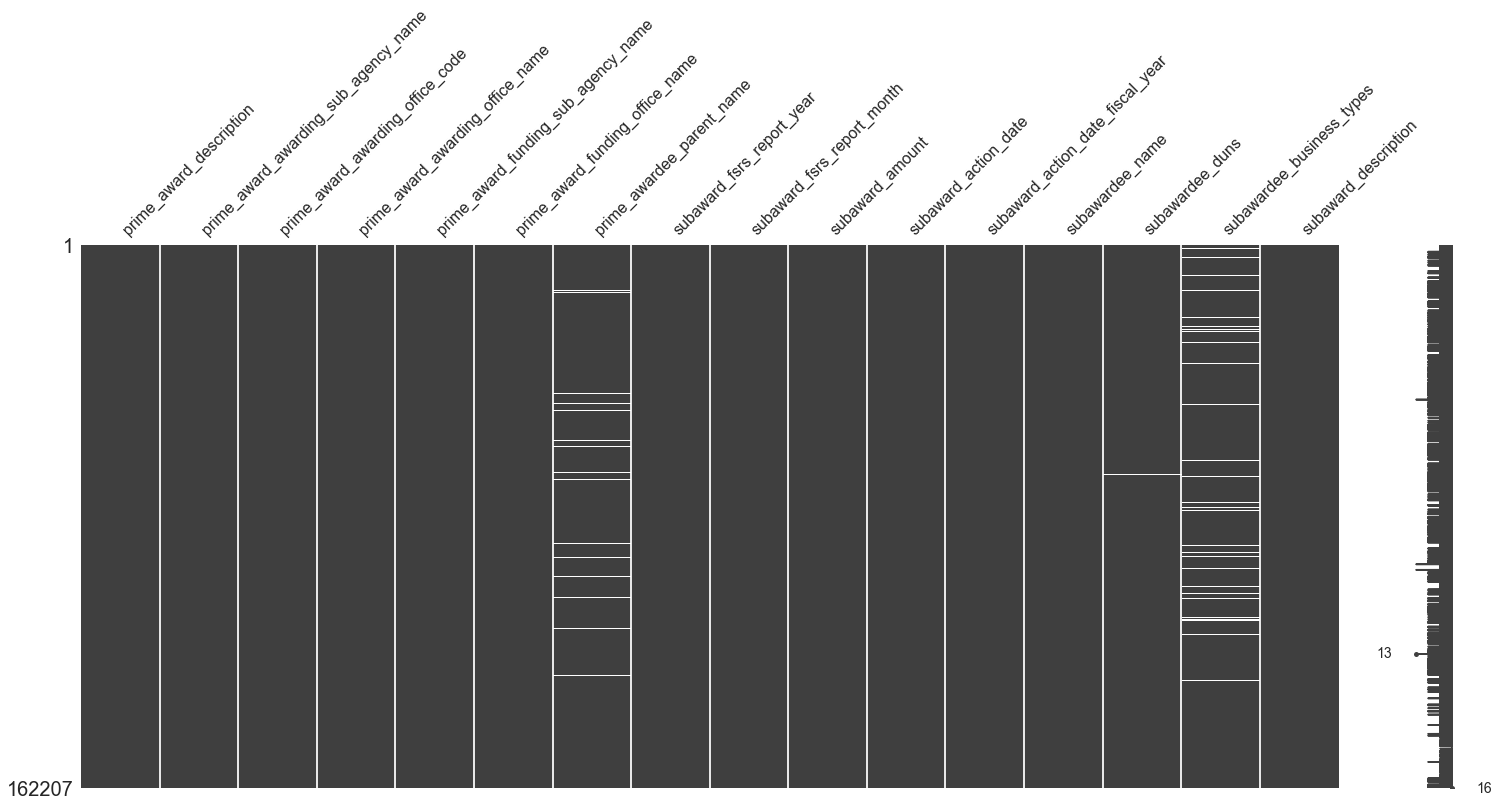

In [12]:
# We now check for missingness in the data.
miss.matrix(data_sub_awards_all)

__Figure 1.__ Observe Missing Values in All Subaward Contract Data

Figure 1 visualizes the missing data in the USAspending data for all contracts. We have limited the data to fewer variables from the original full dataset. The variables that have the most missing values are *prime_awardee_parent_name*, *subawardee_duns*, and *subawardee_business_types*. Each of these features represents variables that will need to be converted to categorical variables. We do further analysis to determine how we can handle the missing values.

In [13]:
# Examine the missing values of the data.
(data_sub_awards_all
 .isna() # Find all missing values.
 .sum() # Sum across columns.
 .reset_index(name = "count") # Reset the index of the dataframe.
 .rename(columns = {"index": "variable"}) # Rename columns.
 .sort_values(by = ["count"], ascending = False) # Sort missing values count in descending order.
 .rename(columns = {"variable" : "Variable", "count": "Count"}) # Rename columns.
)

Variable  Count
14             subawardee_business_types   9020
6              prime_awardee_parent_name   5875
5        prime_award_funding_office_name    525
13                       subawardee_duns    491
15                  subaward_description     31
12                       subawardee_name     18
0                prime_award_description      0
1   prime_award_awarding_sub_agency_name      0
2       prime_award_awarding_office_code      0
3       prime_award_awarding_office_name      0
4    prime_award_funding_sub_agency_name      0
7              subaward_fsrs_report_year      0
8             subaward_fsrs_report_month      0
9                        subaward_amount      0
10                  subaward_action_date      0
11      subaward_action_date_fiscal_year      0

__Table 5.__ Count of Missing Values for Each Variable for All Contracts

The variable that has the most missing values is *subawardee_business_types*. We find that 9.397% of all observations have missing values. Since this is a small portion relative to the total subaward data, we can drop all observations that have missing values from our dataset to continue with our analysis.

In [14]:
# Now we check to see how many observations have missing values.

# Get the number of rows before dropping missing values.
num_before_drop = (data_sub_awards_all
                   .shape[0] # Get the number of rows in the data frame.
                  )

# get the number of rows after dropping missing values.
num_after_drop = (data_sub_awards_all
                  .dropna() # Drop all rows with NA values.
                  .shape[0] # Get the number of rows in the resulting data frame.
                 )

# Get how many rows were dropped for having missing values.
num_missing_obs = num_before_drop - num_after_drop

# Print the percentage of rows in the original data frame that have missing values.
print(f"Percent of Observations with NA Values: {round(100 * num_missing_obs / num_before_drop, 3)}%")

Percent of Observations with NA Values: 9.397%


In [15]:
# Drop all rows with missing values.
data_sub_awards_all = data_sub_awards_all.dropna()

In [16]:
# Check the dimensionality of the resulting dataframe after dropping missing values.
data_sub_awards_all.shape

(146964, 16)

In [17]:
# Collect subaward amount mean and subaward amount count by DUNS.
analysis = \
(data_sub_awards_all[["subawardee_duns", "subaward_amount"]]
 .groupby(["subawardee_duns"])
 .agg({
     "subaward_amount" : ["mean", "count"]
 })
 .reset_index()
 .rename(columns = {"" : "subawardee_duns", 
                    "mean" : "subaward_amount_mean",
                    "count" : "subaward_amount_count"
                   }, level = 1)
 .droplevel(0, axis = 1)
)

In [18]:
# Merge data together.
data_sub_awards_all = data_sub_awards_all.merge(analysis, how = "left", on = "subawardee_duns")

In [19]:
# Only collect hypersonic subawards.
data_sub_awards_hyper = \
data_sub_awards_all[(data_sub_awards_all["prime_award_description"]
                     .str
                     .lower()
                     .str
                     .contains("hypersonic", regex = False)
                    )]

In [20]:
# Check the dimensions of the dataframe.
data_sub_awards_hyper.shape

(103, 18)

In [21]:
# Drop *prime_award_description* columns from dataframes.
data_sub_awards_all = data_sub_awards_all.drop(columns = ["prime_award_description"])
data_sub_awards_hyper = data_sub_awards_hyper.drop(columns = ["prime_award_description"])

# Make copy of dataframes.
data_sub_awards_all_copy = data_sub_awards_all.copy()
data_sub_awards_hyper_copy = data_sub_awards_hyper.copy()

In [22]:
# Collect variables to convert to categories.
cols_to_convert = pd.DataFrame({"columns" : data_sub_awards_hyper.select_dtypes(include = ["int", "object"]).columns})

# Remove "subaward_amount" from columns to convert and make into list to push into for loop.
cols_to_convert = cols_to_convert[~cols_to_convert["columns"].str.contains("amount")]["columns"].values.tolist()

# Add *subawardee_duns* to list of variables to convert to categories.
cols_to_convert.append("subawardee_duns")

In [23]:
# Convert variables to categories.
for column in cols_to_convert:
    data_sub_awards_hyper[column] = data_sub_awards_hyper[column].astype("category")

In [24]:
# We define a function to convert variables to categorical variables and return the altered dataframe.
def conv_cat_dummy(df, var, baseline):
    """
    The conv_cat_dummy function converts a variable to a categorical variable and returns the altered dataframe.
  
    Arguments
    -----
    df: Pandas DataFrame
        A DataFrame of all true values of the target variable, "price".
    
    var: string
        A string of the variable's name to be converted to a categorical variable.
    
    baseline: string
        A string of the variable's baseline to be considered in the convertion to a categorical variable.

    return
    -----
        A Pandas DataFrame with the converted categorical variable.
    """
    
    # Get the dummy variables for given variable.
    dummies = pd.get_dummies(df[var])
    
    # Replace spaces in the dummy column names.
    dummies.columns = [str(c).lower().replace(" ", "_") for c in dummies.columns]
    
    # Drop baseline since we are treating that as our baseline.
    dummies = dummies.drop([str(baseline).lower().replace(" ", "_")], axis = 1) # Baseline
    
    # Concatanate the results to push in to the dummy columns for given variable.
    return pd.concat([df.drop([var], axis = 1), dummies], axis = 1)

In [25]:
# Collect columns that need to be converted to dummy variables.
cols_to_dummy = data_sub_awards_hyper.columns.tolist()

# Remove *subaward_amount_cat*, *subaward_amount_mean*, *subaward_amount_count* from list to be converted to dummy.
cols_to_dummy = [x for x in cols_to_dummy if x not in ["subaward_amount",
                                                       "subaward_amount_mean", 
                                                       "subaward_amount_count"]]

In [26]:
# Iterate through each column that needs to be converted to dummy.
for column in cols_to_dummy:
    # Identify baseline.
    default_to_remove = data_sub_awards_hyper[column].unique()[0]
    
    # Save new dataframe with converted categorical variables to dummies.
    data_sub_awards_hyper = conv_cat_dummy(data_sub_awards_hyper, column, default_to_remove)

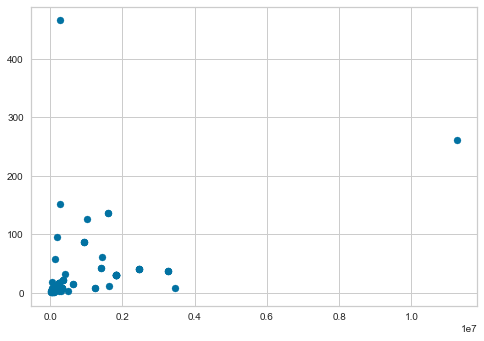

In [27]:
# Plot subaward amount average against subaward amount count.
plt.scatter(data_sub_awards_hyper["subaward_amount_mean"], data_sub_awards_hyper["subaward_amount_count"])

# Show plot.
plt.show()

__Figure 2.__ Number of Subawards Against Average Subaward Amount for Hypersonic Contracts

When we plot the number of subawards against average subaward amount for hypersonic contracts in calendar year 2021, we observe a majority of the contracts are clustered together. However, there are two observations that serve as outliers in both dimensions. The company that represents the outlier for average subaward amount is Honeywell International Inc. The company that represents the outlier for number of subawards is Carahsoft Technology Corp. Of these two companies, Carahsoft Technology Corp. stands out as it provides "government IT solutions", including its solutions in cybsersecurity. With so many subawards given to Carahsoft Technology Corps., the United States government shows its increased interest in digital solutions in the hypersonic space.

In [28]:
# Identify outlier for subaward average amount.
data_sub_awards_hyper_copy.query("subaward_amount_mean > 10000000").subawardee_name.unique()

array(['HONEYWELL INTERNATIONAL INC.'], dtype=object)

In [29]:
# Identify outlier for subaward count.
data_sub_awards_hyper_copy.query("subaward_amount_count > 400").subawardee_name.unique()

array(['CARAHSOFT TECHNOLOGY CORP.'], dtype=object)

In [30]:
# Declare K-Means Clustering model.
model = KMeans(n_clusters = 5)

In [31]:
# Fit model to data.
model.fit(data_sub_awards_hyper)

KMeans(n_clusters=5)

In [32]:
# Get predictions on the entire data set.
all_predictions = model.predict(data_sub_awards_hyper)

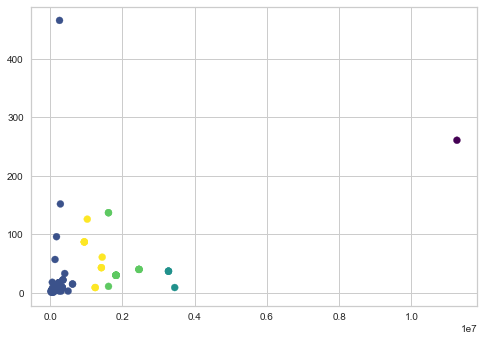

In [33]:
# Plot subaward amount average against subaward amount count with prediction coloring.
plt.scatter(data_sub_awards_hyper["subaward_amount_mean"], 
            data_sub_awards_hyper["subaward_amount_count"], 
            c = all_predictions,
            cmap = "viridis"
           )

# Show plot.
plt.show()

__Figure 3.__ Number of Subawards Against Average Subaward Amount with K-Means Clustering Results for Hypersonic Contracts

We use K-Means Clustering to identify any group relationships between the subawards within the USAspending data for hypersonic contracts. K-Means Clustering partitions the observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. Figure 3 shows the results of the clustering unsupervised algorithm over the plot of number of subawards against average subaward amount. We use 5 clusters in the K-Means Clustering algorithm. Our results show the clustering works through the average subaward amount and not through the number of subawards. We cannot gain much insight into the results of the K-Means Clustering since our grouping is only seen against one variable. If we were to convert the subaward amount into an ordinal variable, we would most likely observe the same binning as we do in the results from the K-Means Clustering as we would have defined the bins for the ordinal variable.

In [34]:
# Define T-SNE Clustering model.
model = TSNE(learning_rate = 100, random_state = 999)

In [35]:
# Fit model to data.
transformed = model.fit_transform(data_sub_awards_hyper)

In [36]:
# Plot the 2D T-SNE.
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

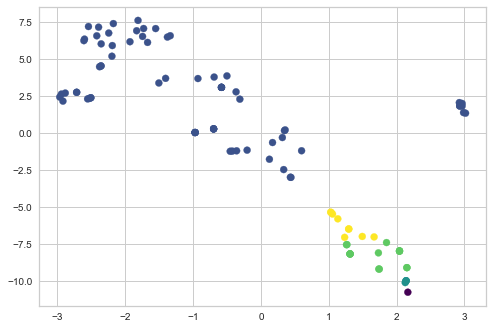

In [37]:
# Plot transformed data that is now represented in a two-dimensional figure.
plt.scatter(x_axis, y_axis, c = all_predictions, cmap = "viridis")

# Show plot.
plt.show()

__Figure 4.__ Results of T-SNE Clustering Model with Dimension Reduced Data for Hypersonic Contracts

We visualize the high-dimensional data using a t-distributed stochastic neighboring embedding and then map the results of the K-Means Clustering onto the reduced plot, as seen in Figure 4. Since we reduced the dimensionality of the data to two dimensions, it is difficult to identify true outliers among the clusters. We observe from the results of the K-Means Clustering that a clear clustering occurs once we reduce the dimensionality of the data but we are unable to make any clear sense of the results since the plot labels are not well defined. The least we can say is the grouping to the far right may be a group of outliers within the "purple" clustered group. We can do further analysis to determine if these observations in this group are indeed anomalies.

In [38]:
# Set up Pycaret using the original copy of the data.
anom = setup(data = data_sub_awards_hyper_copy, silent = True, session_id = 999)

In [39]:
# Train the anomaly detection model.
anom_model = create_model(model = "iforest", fraction = 0.05)

In [40]:
# Score the dataset.
results = assign_model(anom_model)

In [41]:
# Plot the model to help us visualize high dimension data using TSNE.
plot_model(anom_model, plot = "tsne")

__Figure 5.__ Anomaly Detection Model Results for Hypersonic Contracts - 3D T-SNE Plot for Outliers

Figure 5 represents the results of the anomaly detection model using hypersonic subaward contract data. We use anomaly detection to identify rare items, events or observations which deviate significantly from the majority of the data and do not conform to a well defined notion of normal behaviour. We create an Isolation Forest where the algorithm differentiates observations by randomly selecting a feature and then randomly selecting split values between the maximum and minimum values. We observe several anomalies within our set of hypersonic subawards which we will explore in further detail. Since we again reduced the dimensionality of the data to now three dimensions, it is still difficult to understand what makes these anomalies true outliers within the dataset.

In [42]:
# Save plot as HTML file.
plot_model(anom_model, plot = "tsne", save = True)

'tsne'

In [43]:
# Get anomaly predictions for the data we used.
data_predictions = predict_model(anom_model, data = data_sub_awards_hyper_copy)

In [44]:
# Identify only the anomalies by company name.
anom_companies = \
pd.DataFrame({"Anomaly Company" : data_predictions.query("Anomaly == 1").subawardee_name.unique()})

# Show results.
display(anom_companies)

Anomaly Company
0                         CUBRC, INC.
1  INTERSTATE ELECTRONICS CORPORATION
2           HYSONIC TECHNOLOGIES, LLC
3         LOCKHEED MARTIN CORPORATION
4                 SIRIUS FEDERAL, LLC

__Table 6.__ Anomalies by Company Name for Hypersonic Contracts

We identify the companies associated with the anomalies we detected in the anomaly detection model. Lockheed Martin Corporation stands out across these companies as a relatively large company across all subawardees. We expect to see Lockheed Martin as an important contributor in the hypersonic space and would always be a target for cybersecurity attacks simply based on its logistical position as one of the largest aerospace developers in the United States. As for the other companies, quick Google searches showed each company's significance in hypersonic development. For example, several recent articles discuss CUBRC, Inc. receiving large contracts from the Department of Defense. HySonic Technologies, LLC. have several articles published in the past month (April 2022) detailing its contribution to reusable hypersonic flight testing, a critical part in the development of the entire technology.

In [45]:
# Identify only the anomalies by description.
anom_desc = \
pd.DataFrame({"Anomaly Description" : data_predictions.query("Anomaly == 1").subaward_description.unique()})

# Show results.
display(anom_desc)

Anomaly Description
0                  Lightning Arrestors, NRE - Other.
1                               Engineering Services
2                                       NRE - Other.
3  In support of the project on the reference lin...
4  SSD Shelf,12G,24x960GB,-QS, SW,Per-0.1TB,Flash...

__Table 7.__ Anomalies by Subaward Description for Hypersonic Contracts

We identify the subaward descriptions associated with the anomalies we detected in the anomaly detection model. These results do not give particular insight regarding the anomalies and why they were detected. We can further this analysis by mapping these descriptions to all hypersonic contracts to see if we observe similar company specific results.

In [46]:
# Merge anomaly data with the top descriptions for hypersonic.
data_top_descriptions_hyper_anom = \
(data_sub_awards_hyper_copy
 .merge(anom_desc, how = "inner", left_on = "subaward_description", right_on = "Anomaly Description")
)

In [47]:
# Collect results for the companies that have the most contracts for the top descriptions for hypersonic anomalies.
results_hyper_anom = \
(data_top_descriptions_hyper_anom[["subawardee_name", "subaward_description", "subaward_amount"]]
 .groupby(["subawardee_name", "subaward_description"])
 .agg({
     "subaward_amount" : ["mean", "count"]
 })
 .reset_index()
 .round(2)
 .droplevel(0, axis = 1)
 .sort_values(by = ["count"], ascending = False)
 .dropna()
 .head(10)
)

# Rename columns.
results_hyper_anom.columns.values[0] = "Sub-Awardee Name"
results_hyper_anom.columns.values[1] = "Sub-Awardee Description"
results_hyper_anom.columns.values[2] = "Sub-Awardee Average Amount"
results_hyper_anom.columns.values[3] = "Sub-Awardee Count"

# Show results.
display(results_hyper_anom)

Sub-Awardee Name  \
0             CORVID TECHNOLOGIES LLC   
2           HYSONIC TECHNOLOGIES, LLC   
1                         CUBRC, INC.   
3  INTERSTATE ELECTRONICS CORPORATION   
4         LOCKHEED MARTIN CORPORATION   
5                 SIRIUS FEDERAL, LLC   

                             Sub-Awardee Description  \
0                                       NRE - Other.   
2                                       NRE - Other.   
1                  Lightning Arrestors, NRE - Other.   
3                               Engineering Services   
4  In support of the project on the reference lin...   
5  SSD Shelf,12G,24x960GB,-QS, SW,Per-0.1TB,Flash...   

   Sub-Awardee Average Amount  Sub-Awardee Count  
0                   154168.00                  2  
2                    99400.00                  2  
1                   430072.00                  1  
3                   272641.38                  1  
4                    58093.00                  1  
5                    51654.94                  1

__Table 8.__ Companies with the Most Contracts for Top Subaward Descriptions for Hypersonic Anomalies

Once we match the anomaly descriptions to the descriptions across the set of hypersonic subawards, we observe similar company results for when we identified the companies directly from the anomaly detection algorithm. We can assume the descriptions themselves are what caused the anomalies to appear in the first place. However, we will need to do additional anomaly detection to see if there is a true link between subaward description and the identified anomalies. As a counterfactual assumption, the descriptions associated with the anomalies are general for the most part, which could contradict our previous assumption that these descriptions could lead to observations being identified as anomalies since a general description could be used for many contracts across all subawards, let alone hypersonic ones.

#### 3. Conclusion and Final Remarks

Even though our initial goal of creating a cybersecurity risk evaluation metric was not successful, we identified companies that serve as critical contributors to hypersonic technology development that could act as cybersecurity targets from American adversaries. Our analysis focuses on data wrangling to find specific companies that could favor from additional government support within the digital sphere. Of the companies we identified, the ones that stand out the most with respect to the data analysis, machine learning, and associated media coverage are Optical Sciences Corporation, Bendix Commercial Vehicle Systems LLC, and HySonic Technologies, LLC. Of the companies that are identified and assumed to have a critical role in hypersonic development and should already have significant infrastructure in place to handle cybersecurity attacks, Lockheed Martin Corporation shares slightly under 20% of the entire aerospace market as of the end of the calendar year 2021. Our analysis was successful in both identifying companies that could benefit from additional support and companies that should have cybersecurity measures since they represent large portions of the respective market.

One specific area of concern is the small number of observations we used in our unsupervised machine learning algorithms. The algorithms could perform better with a larger number of subawards, but we must be wary of model bias and variance. Another consideration is whether or not the results are truly tied to cybersecurity issues. The results indeed found companies that could be targets. However, these companies could also be examples of some other unknown factor(s) within the data.

Even though we focused our analysis to hypersonic subaward contracts, our findings show that our approach can be extended to any other emerging technology the United States government has shown interest. Such other technologies include artificial intelligence, quantum information technologies, biotechnologies, and space technologies and systems.

To continue in our initial effort to create such a cybersecurity risk evaluation metric, I aim to meet with NSA officials who originally sponsor the Hacking for Defense team. I hope to gain additional insight as to new ways to supplement the USAspending data and to explore other venues of analysis. Their insights could contribute to developing a dashboard where the emerging and critical technology could be selected and companies, descriptions, business types, etc. are highlighted as those with increased risks of cybersecurity attacks. Such a dashboard could reduce unnecessary efforts to analyze large amounts of data in favor of a readily available system at the disposal of the United States government and other cybersecurity participants.

I would like to thank Professor Gregory Lyon for his introduction to the Hacking for Defense program and his support throughout this project. I would also like to thank Thomas Keelan who was my partner within the Hacking for Defense program. Thomas helped narrow my focus and motivated my approach to the question at hand.